# Deep Reinforcement Learning: Serial Kinematic

---

This projects demonstrates an agent learning to control a serial kinematic to follow a sphere using **Deep Reinforcement Learning**.

### 1. Start the Environment

We begin by importing the necessary packages. If the code cell below returns an error, please revisit Prequisited and Installation Section in the README.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
%matplotlib inline

The environment is included in this repository. You can either train a single serial kinematic (simulation/Reacher.exe) or multiple simultaneously (simulation_multi/Reacher.exe).

In [2]:
env = UnityEnvironment(file_name='simulation_multi/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.16249999636784196


When finished, you can close the environment.

### 4. Train the Agent from Skretch using Deep Deterministic Policy Gradient (DDPG)

In the follwing, the environment will be solved by training the agent to control the serial kinematic using Deep Deterministic Policy.

In [6]:
from models import Actor, Critic
from agents import Agent

In [7]:
env_info = env.reset(train_mode=True)[brain_name]
agent = Agent(state_size=len(env_info.vector_observations[0]), action_size=brain.vector_action_space_size, num_agents=num_agents , random_seed=2)

### 4.1 Learning Algorithm
The learning algorithm uses *Deep Deterministic Policy Gradient (DDPG)*. For a total of n_episodes the agents choses an action based on the current state and collects the subsequent state/next_state and the reward as result of his previous chosen action.

With the state, action, reward and next_state information, the agent adds these information to the replay buffer using the step function, which is implemented in agent class defined in the agent.py. 

The *actor network* approximate the optimal policy and outputs the believed best action using the states as input, the *critic network* learns to evaluate the optimal action value function by using the *actors* best belived action and the state.

If the mean score for the last 100 episodes is above the goal of 30, the current model is saved. It would also be possible to stop the training here, but for visualize how good the model can perform with the maximum number of episodes (determinde by n_episodes), the training continues after reaching the goal until the score starts to decrease.

In [8]:
def ddpg(n_episodes=500, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores_window = deque(maxlen=100)  # last 100 scores
    scores = []
    average_score = []                 # List for average score of 100 episodes
    best_score_window = 0
    
    for i_episode in range(1, n_episodes+1):
        states = env.reset(train_mode=True)[brain_name].vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards

            next_states = env_info.vector_observations
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += env_info.rewards
            if np.any(dones):
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        scores_window.append(np.mean(score))
        average_score.append(np.mean(scores_window))

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
        if np.mean(scores_window)>=30.0 and np.mean(scores_window)>best_score_window:
            print('\rDONE: Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            best_score_window = np.mean(scores_window)
            torch.save(agent.actor_local.state_dict(), 'best_checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'best_checkpoint_critic.pth')
        if np.mean(scores_window)>=30.0 and np.mean(scores_window)<best_score_window:
            break
        
    return scores, average_score

### 4.2 Hyperparameters

The actor and critic models are then trained using the following hyper parameters:
A replay buffer size of 1e6, a minibatch size of 512, a discount factor gamma of 0.99, soft-update factor of 1e-2, the learning rate of the actor of 1e-4 and of 1e-3 for the critic. L2 weight decay is not applied.

In [9]:
scores, average_score = ddpg()

C:\Users\Sebas\miniconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 23.70
Episode 139	Average Score: 32.27 32.31

### 4.3 Model Architecture
The model for the **actor** and **critic** are defined in *models/ddpg_model.py*.<br>
The **actor** architecture uses batch normalization followed by four linear layer with an input size corresponding to the state dimension, 128, 256, 128 hidden units and finally an output of the size of the action size.
The **critic** architecture uses batch normalization followed by four linear layer with an input size corresponding to the state dimension, 128+action_size, 256, 128 hidden units and finally an output of one.<br>
Both models use leaky relu as activation function.

### 4.4 Plot of Rewards per Episode

Subsequently you can see a plot of the score over the number of episodes:

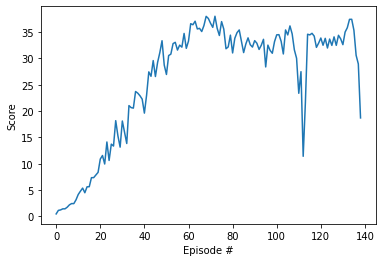

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

And in addition, the average score for the a 100 episodes window

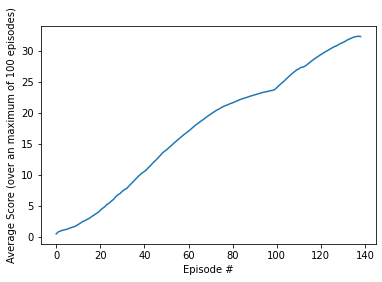

In [11]:
# plot the average scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(average_score)), average_score)
plt.ylabel('Average Score (over an maximum of 100 episodes)')
plt.xlabel('Episode #')
plt.show()

### 4.5 Ideas for Future Work
The following stept could help to further improve the performance:
- **More sophisticated network architecture**<br>
    The used network is a very shallow network. A deeper and more sophisticated network might perform better
- **Compare against other Actor-Critic Methods**<br>
Compare against Asynchronous Advantage Actor-Critic (A3C), Advantage Actor-Critic (A2C) and Generalized Advantage Estimation (GAE). Then chose the best performing technique.

### 5. Demonstrate Trained Agent

Now let's load the best performing model and let us see, how it performs.

In [ ]:
#Visualize best result

#agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

agent.actor_local.load_state_dict(torch.load('best_checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('best_checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
states = env_info.vector_observations              # get the current state
score = 0                                          # initialize the score
while True:
    actions = agent.act(states, add_noise=False)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    states = next_states
    score += np.mean(env_info.rewards)
    if np.any(dones):
        break 
    
print("Score: {}".format(score))

### 6. Shutdown Environment

Last thing to do is to shut down the environment

In [13]:
env.close()